In [1]:
import argparse
import torch
import torch.nn as nn
import dgl
import torch.optim as optim
from dgl.dataloading import MultiLayerFullNeighborSampler, EdgeDataLoader
from dgl.dataloading.negative_sampler import Uniform
import numpy as np
import pandas as pd
import itertools
import os
import tqdm
import matplotlib.pyplot as plt
from dgl import save_graphs, load_graphs
import dgl.function as fn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv, SAGEConv, HeteroGraphConv
from dgl.utils import expand_as_pair
from collections import defaultdict
import torch as th
import dgl.nn as dglnn
from dgl.data.utils import makedirs, save_info, load_info
from sklearn.metrics import roc_auc_score
import gc
from thefuzz import fuzz
from thefuzz import process
import time
import re

gc.collect()

18

In [147]:
# file1 = 'C:/Users/qiang/Documents/coding/harvard-individuals.csv' ## Windows file location, harvard index collector
## file1 = '~/Downloads/harvard-individuals.csv'  ## macOS file location, harvard index collector
file1 = '~/Downloads/harvard-index-collectors.csv'  
harvard_data = pd.read_csv(file1,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
harvard_data = pd.concat(harvard_data)
harvard_columns = harvard_data.columns.tolist()
harvard_data.rename(columns={harvard_columns[8]:'labelName'}, inplace=True) ## to avoid special character in colNames

harvard_columns = harvard_data.columns.tolist()   ## load content into list
harvard_data.head()

,Unnamed: 0.1,Unnamed: 0,id,Name,First date collected,Remarks,ASA Botanist ID,GUID,labelName,Full Name,...,First date received,End Date,Specialty,URL,Last date received,Geography,Vernacular name,Image,Agent type,Team Members:
0,0,0.0,47342,"Hepp, R.",1946,[collector note: SGO],147721 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,R. Hepp,"Hepp, R.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,14911,"Palazzi, Andrea",NaN,[collector note: Herbarium (Piedmont (Italy): TO],114969 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,A. Palazzi,"Palazzi, Andrea",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,29488,"Nicholls, Robert",NaN,"[collector note: BM-SL, OXF.]",129688 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,Robert Nicholls,"Nicholls, Robert",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,44660,"Hosie, R. C.",1937,"[collector note: Ontario, Algoma Dist., Thunde...",145012 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,R. C. Hosie,"Hosie, R. C.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,10131,"Lohman, M. L.",NaN,[collector note: Type collection: FH],110149 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,M. L. Lohman,"Lohman, M. L.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
# file2 = 'C:/Users/qiang/Documents/coding/wikidata-collectors-230615.csv'  ## Windows file location, wikipedia collector
file2 = '~/Downloads/wikidata-collectors-230615.csv'  ## macOS file location, wikipedia collector

wiki_data = pd.read_csv(file2,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
wiki_data = pd.concat(wiki_data)
wiki_columns = wiki_data.columns.tolist()   ## load content into list
wiki_data.head()

,id,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,sexOrGender,VIAF,IPNI,harvardIndex,authorAbbrv,birthName
0,Q100142069,Frida Eggens,NaN,NaN,NaN,['SE'],['Q34'],['Eggens'],NaN,NaN,female,NaN,20045232-1,NaN,Eggens,NaN
1,Q100146795,Elizabeth Harrison,NaN,+1792-12-00T00:00:00Z,NaN,['GB'],"['Q161885', 'Q174193']","['Mrs Arnold Harrison', 'Mrs A. H.']",Q100146795,+1834-01-05T00:00:00Z,female,NaN,NaN,NaN,NaN,NaN
2,Q100149196,Russell Cox,['9cfe8cbf-35ff-4d93-b932-cb05d91b7922'],NaN,NaN,NaN,NaN,[],0000-0001-5149-1709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q100152296,Alda Pereira da Fonseca,NaN,+1882-00-00T00:00:00Z,NaN,['BR'],['Q155'],[],NaN,NaN,female,NaN,NaN,NaN,NaN,NaN
4,Q100156193,Laurence Henry Millener,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],+1914-04-01T00:00:00Z,NaN,['NZ'],['Q664'],"['L. H. Millener', 'Laurie Henry Millener', 'L...",Q100156193,+2000-00-00T00:00:00Z,male,NaN,NaN,NaN,NaN,NaN


In [5]:
matches = set(harvard_columns).intersection(set(wiki_columns))
print(harvard_columns)
print(wiki_columns)
print(matches)
print(len(matches))

['Unnamed: 0', 'id', 'Name', 'First date collected', 'Remarks', 'ASA Botanist ID', 'GUID', 'labelName', 'Full Name', 'Geography Collector', 'Citation as Collector', 'Date of birth', 'Date of death', 'Last date collected', 'Member of teams/groups', 'Holdings', 'Collections in', 'Collector Teams:', 'Variant name', 'Specialty Collector', 'First date flourished', 'Geography Determiner', 'Specialty Determiner', 'Citation as Determiner', 'Author name', 'B\xa0&\xa0P\xa0Author\xa0Abbrev.', 'Geography Author', 'Specialty Author', 'Citation as Author', 'Author Teams:', 'Last date flourished', 'Author in', 'Start Date', 'First date received', 'End Date', 'Specialty', 'URL', 'Last date received', 'Geography', 'Vernacular\xa0name', 'Image']
['id', 'label', 'institutions', 'dateOfBirth', 'ISNI', 'countryOfCitizenshipISO', 'countryOfCitizenship', 'aliases', 'bionomia', 'dateOfDeath', 'sexOrGender', 'VIAF', 'IPNI', 'harvardIndex', 'authorAbbrv', 'birthName']
{'id'}
1


In [4]:
# Method to compute and plot the data distribution of a given dataframe
def get_distribution(data, col):
    sum_count = 0
    data_distribution = {} ## a dictionary to store the distribution of individual entity
    data_distribution_sum = pd.DataFrame(columns = col, index=['sum'])
    for (columnName, columnData) in data.iteritems():
        temp = data[columnName].value_counts()
        data_distribution_sum.at['sum', columnName]=sum(temp)
    return data_distribution_sum

                           sum
id                       71988
aliases                  71988
label                    71740
authorAbbrv              53828
IPNI                     53822
sexOrGender              50176
dateOfBirth              38647
harvardIndex             33413
dateOfDeath              27032
countryOfCitizenship     25364
VIAF                     23591
countryOfCitizenshipISO  22431
ISNI                     17629
bionomia                 12228
institutions             11113
birthName                 1099


<AxesSubplot:title={'center':'WikiData'}>

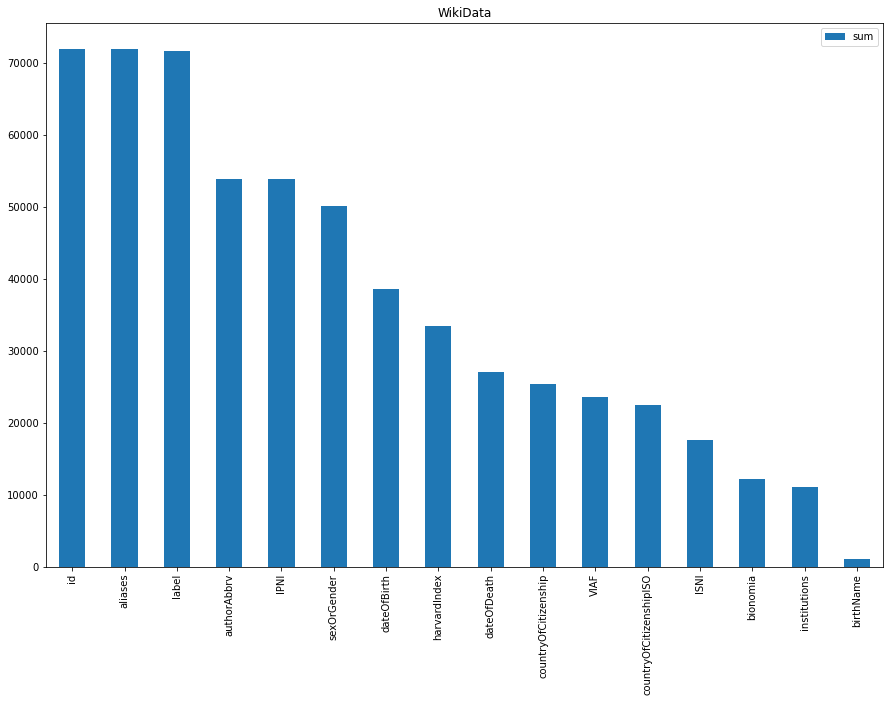

In [73]:
distribution = get_distribution(wiki_data, wiki_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'WikiData')

                           sum
Unnamed: 0.1            114293
id                      114293
Name                    114289
GUID                    113006
labelName               106954
Full Name               103773
Unnamed: 0               98690
Remarks                  87736
ASA Botanist ID          87196
Citation as Collector    67598
Geography Collector      67129
Variant name             47292
Specialty Collector      42523
B & P Author Abbrev.     40890
Author name              39340
Specialty Author         38252
Citation as Author       37260
Date of birth            34246
Holdings                 33524
Collections in           33524
First date collected     33289
Geography Author         20333
Collector Teams:         20268
Date of death            17859
Agent type               15425
Team Members:            15195
First date flourished    14666
Author Teams:             6563
Start Date                4381
Author in                 3589
Last date collected       2736
First da

<AxesSubplot:title={'center':'Harvard Index'}>

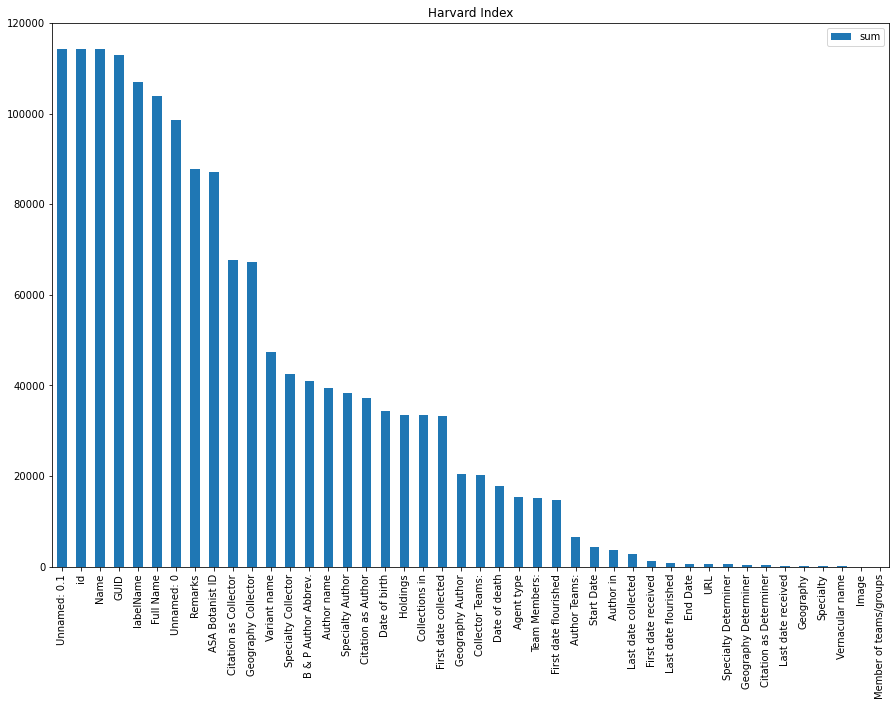

In [74]:
distribution = get_distribution(harvard_data, harvard_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'Harvard Index')

In [ ]:
cols_to_drop_h = ['Unnamed: 0.1','Unnamed: 0','Geography Author', 'Geography Collector', 'Geography Determiner', 
                  'Geography','Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty' ]
flight_data_copy.drop(cols_to_drop, axis=1, inplace=True)

In [46]:
temp = wiki_data["countryOfCitizenshipISO"][10020] # "countryOfCitizenshipISO" and "countryOfCitizenship"
a = ""
b = a.join(char for char in temp if char.isalnum())
print(b)

temp = wiki_data["aliases"][10020] # "aliases"
b = temp.replace('[', '').replace(']','').replace("'", '')
print(b)

US
Leslie David Gottlieb, Gottlieb


In [81]:
a = wiki_data[['id', 'aliases']].copy()
a['aliases'] = remove_spec_in_col(a,'aliases')
a.iloc[[10020]]

,id,aliases
10020,Q16019400,"Leslie David Gottlieb, Gottlieb"


In [5]:
'''
# this function will remove all special charaters -- including spaces
# but too slow comparing to replace -- used process_time() for evaluation
def clean_text(text): # fa
    a = ""
    text = a.join(char for char in text if char.isalnum())
    return text
'''
# Remove square blankets auto generated during data alignment process
def clean_text(text): # fb
    text = text.replace('[', '').replace(']','').replace("'", '')
    return text

def remove_spec_in_col(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(clean_text(rowValue))
        else:
            newCol.append(np.nan)
    return newCol

In [18]:
temp = wiki_data["aliases"][10020]

start = time.process_time()
print(clean_text(temp))   
print(time.process_time() - start)

# start = time.process_time()
# print(fb(temp)) 
# print(time.process_time() - start)

Leslie David Gottlieb, Gottlieb
0.002020000000001687


In [84]:
# fuzz.token_set_ratio("Davis, Helen Burns", "helen burns davis")
temp = wiki_data.iloc[[120]].T
print(temp)
temp = harvard_data.iloc[[10000]].T
print(temp)

                                           120
id                                  Q101069525
label                          Even Trætteberg
institutions                               NaN
dateOfBirth              +1871-02-08T00:00:00Z
ISNI                                       NaN
countryOfCitizenshipISO                 ['NO']
countryOfCitizenship                   ['Q20']
aliases                                     []
bionomia                            Q101069525
dateOfDeath              +1949-02-08T00:00:00Z
sexOrGender                               male
VIAF                                       NaN
IPNI                                       NaN
harvardIndex                               NaN
authorAbbrv                                NaN
birthName                                  NaN
                                                                    10000
Unnamed: 0.1                                                        10000
Unnamed: 0                                           

In [23]:
text1 = "[author note: Types at: MT] [collector note: col. with M. St-Arnaud; MT; BO]"
text2 = "[collector note: Herbarium (Piedmont (Italy): TO]"
text3 = "[collector note: SAFB] plant pathologist; short biography and photo: Can. J. Plant Pathol. Vol. 28: S21-S22. 2006."
text4 = "[collector note: BM-SL, OXF.]"
text5 = "[collector note: Herbarium and types, US, additional m,erial , B, C, DBN, GH, K, MIN, MO, NA, NY, PH"
text = "[author note: LE; temperate Asian Polygonaceae] [collector note: LE] "
temp = text4.split("[")
s1 = ""
s2 = ""
print(temp)
for i in temp:
    # i = clean_text(i)
    print("\nFor loop: " + i)
    s1 = i.partition("author note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',')
    print("author note: ", get_herbarium_codes(s1))
    
    s2 = i.partition("collector note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',')
    print("collector note: ", get_herbarium_codes(s2))

'''
# not robust enough comparing to the inbulid string partitioning
import re
m = re.search('author note: (.+?);', text)
if m:
    found = m.group(1)
print(found.replace(";", ''))
'''
s1 = get_author_notes(temp)
s2 = get_collector_notes(temp)
print("\nFunction version:")
print("author note: ", s1)
for i in s1: print("\nHerbarium List: ", get_herbarium_codes(i))
print("collector note: ", s2)
for i in s2: print("\nHerbarium List: ", get_herbarium_codes(i))

['', 'collector note: BM-SL, OXF.]']

For loop: 
author note:  []
collector note:  []

For loop: collector note: BM-SL, OXF.]
author note:  []
collector note:  ['BMSL', 'OXF']

Function version:
author note:  []
collector note:  ['BM-SL, OXF.']

Herbarium List:  ['BMSL', 'OXF']


In [6]:
# Functions to extract the herbarium institution codes from Remarks in Harvard Index
def get_herbarium_codes(string):
    herbarium_codes = []
    for s in string.split(","):
        if s.isupper():
            herbarium_codes.append(re.sub('[^A-Z]', ',', s).replace(",",""))
    return herbarium_codes
            
def get_author_notes(string):
    authorNotes = []
    for s in string:
        # s = clean_text(s)
        # authorNotes.append(s.partition("author note: ")[2].partition(" ")[0].replace(";", ''))
        authorNotes.append(s.partition("author note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    authorNotes = list(filter(None, authorNotes))
    return authorNotes

def get_collector_notes(string):
    collectorNotes = []
    for s in string:
        # s = clean_text(s)
        # collectorNotes.append(s.partition("collector note: ")[2].partition(" ")[0].replace(";", ''))
        collectorNotes.append(s.partition("collector note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    collectorNotes = list(filter(None, collectorNotes))
    return collectorNotes

def get_author_collector_notes(df, col):
    authorNoteCol = []
    collectorNoteCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            string = rowValue.split("[")
            authorNoteCol.append(get_author_notes(string))
            collectorNoteCol.append(get_collector_notes(string))
        else:
            authorNoteCol.append(np.nan)
            collectorNoteCol.append(np.nan)
    return authorNoteCol, collectorNoteCol

In [154]:
def extract_herbariums(df, col):
    newCol = []
    temp = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            for i in rowValue: temp = get_herbarium_codes(i)
            newCol.append(temp)
        else:
            newCol.append(np.nan)
    return newCol

In [14]:
temp = harvard_data[['id', 'Remarks']].copy()
print(temp)

a, b = get_author_collector_notes(temp, 'Remarks')

           id                                            Remarks
0       47342                              [collector note: SGO]
1       14911  [collector note: Herbarium (Piedmont (Italy): TO]
2       29488                      [collector note: BM-SL, OXF.]
3       44660  [collector note: Ontario, Algoma Dist., Thunde...
4       10131              [collector note: Type collection: FH]
...       ...                                                ...
114288  98272                                                NaN
114289  98278                                                NaN
114290  98280                               [collector note: TN]
114291  98286                                              (LAE)
114292  98287                               [collector note: MN]

[114293 rows x 2 columns]


In [155]:
a, b = get_author_collector_notes(harvard_data, 'Remarks')
harvard_data['author note'] = a
harvard_data['collector note'] = b
harvard_data['author note'] = extract_herbariums(harvard_data,'author note')
harvard_data['collector note'] = extract_herbariums(harvard_data,'collector note')

/var/folders/gf/wqsz1zkd6x95xx3fgy6qr2780000gn/T/ipykernel_57988/411441977.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pd.notnull(rowValue):


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [153]:
harvard_data['author note'].value_counts()

[]                                                                                               104352
[K]                                                                                                 180
[B]                                                                                                 130
[BM]                                                                                                108
[MO]                                                                                                107
                                                                                                  ...  
[BM, AK, BERN, CGE, DBN, DPU, E, EBH, FI, FRS, G, K, KIEL, L, MANCH, NEU, NMW, OXF, PH, U, W]         1
[S, GB, NMW]                                                                                          1
[MPU, AL, FI, LY, P, W]                                                                               1
[MSTR, B, BHU, BR, BREM, DBN, E, FI, GB, GOET, H, HAL, KIEL, LE,

In [124]:
temp = harvard_data['Remarks'].value_counts()
print(temp)

[author note: Herbarium and types unknown]                                                                            2492
[collector note: BR]                                                                                                   406
[collector note: A]                                                                                                    383
[collector note: MO]                                                                                                   379
[collector note: K]                                                                                                    293
                                                                                                                      ... 
[author note: LE; temperate Asian Polygonaceae] [collector note: LE]                                                     1
[collector note: E (col. 1934)]                                                                                          1
[author note: Ty

In [62]:
# Extract geography locations and travel history related to collectors
def combine_geography(df):
    cols = ['Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']
    newCol = df[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        if pd.notnull(rowValue):
            newCol[index] = set(clean_text(rowValue).replace('\xa0 ','').split(','))
        else:
            newCol[index] = np.nan
    return newCol

In [63]:
temp = harvard_data[['id','Name','Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']].copy()
cols = ['Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']
temp['combine_geography'] = combine_geography(temp)
temp['combine_geography'].value_counts().index.tolist()

[{''},
 {'United States of America'},
 {'Brazil'},
 {'China'},
 {'Germany'},
 {'Mexico'},
 {'Canada'},
 {'France'},
 {'India'},
 {'Australia (Country)'},
 {'Colombia'},
 {'Russia'},
 {'Indonesia'},
 {'California'},
 {'Japan'},
 {'Argentina'},
 {'South Africa'},
 {'Italy'},
 {'Sweden'},
 {'Malaysia'},
 {'Ecuador'},
 {'Peru'},
 {'Venezuela'},
 {'Spain'},
 {'Papua New Guinea'},
 {'Czech Republic'},
 {'Netherlands'},
 {'Switzerland'},
 {'Philippines'},
 {'Finland'},
 {'Costa Rica'},
 {'Belgium'},
 {'Austria'},
 {'Panama'},
 {'Denmark'},
 {'Cuba'},
 {'Bolivia'},
 {'Poland'},
 {'New Zealand'},
 {'Thailand'},
 {' Democratic Republic of the', 'Congo'},
 {'Mexico', 'United States of America'},
 {'Chile'},
 {'Portugal'},
 {'Norway'},
 {'Turkey'},
 {'Canada', 'United States of America'},
 {'Hungary'},
 {'Madagascar'},
 {'Nigeria'},
 {'United Kingdom'},
 {'Nepal'},
 {'Vietnam'},
 {'Ireland'},
 {'Tanzania'},
 {'Pakistan'},
 {'Jamaica'},
 {'Iran'},
 {'Romania'},
 {'Kenya'},
 {'Greenland'},
 {'Guyana

In [64]:
temp['combined'].value_counts()

{}                                           34818
{United States of America}                   17940
{Brazil}                                      3261
{China}                                       2922
{Germany}                                     2717
                                             ...  
{Norway, Greenland, Switzerland, Denmark}        1
{Netherlands, Thailand, Indonesia}               1
{Sierra Leone, Germany, Cameroon}                1
{India, Greece, Hungary}                         1
{Quebec Province, New York}                      1
Name: combined, Length: 4072, dtype: int64

In [17]:
temp = harvard_data['Geography Author'].value_counts()
print(temp)
print()
temp = harvard_data['Geography Collector'].value_counts()
print(temp)
print()
temp = harvard_data['Geography Determiner'].value_counts()
print(temp)
print()
temp = harvard_data['Geography'].value_counts()
print(temp)

United States of America                                               3644
Germany                                                                2440
France                                                                 1348
China                                                                  1197
India                                                                   909
                                                                       ... 
Belgium,  Cuba,  Czech Republic,  Mexico,  United States of America       1
Costa Rica,  Ecuador,  Guatemala,  United States of America               1
France,  Madagascar,  Vietnam                                             1
Argentina,  Brazil,  Chile                                                1
Africa (Region)                                                           1
Name: Geography Author, Length: 974, dtype: int64

United States of America                                                          12178
Brazil                   

In [51]:
temp = harvard_data[['id','Name','Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']].copy()
cols = ['Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']
# temp['combined'] = temp['Specialty Author'].combine_first(temp['Specialty Collector']).combine_first(temp['Specialty Determiner']).combine_first(temp['Specialty'])
temp['combined'] = temp[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
temp['combined'].value_counts().index.tolist()

['',
 'Spermatophytes',
 'Phanerogams',
 'Fungi and Lichens',
 'Algae',
 'Spermatophytes,Phanerogams',
 'Bryophytes',
 'Fungi',
 'Pteridophytes',
 'Lichens',
 'Fossils',
 'FungiAndLichens',
 'Fungi and Lichens,Fungi',
 'Angiosperms',
 'Spermatophytes,Pteridophytes',
 'Fungi and Lichens,Lichens',
 'Mosses',
 'Spermatophytes,Lichens',
 'Spermatophytes,Fungi',
 'Diatoms',
 'Pre-Linnean',
 'Hepatics',
 'Spermatophytes,Bryophytes',
 'Fungi and Lichens,Phanerogams',
 "['Phanerogams', 'Pteridophytes']",
 'Spermatophytes,Algae',
 'FungiAndLichens,Fungi',
 'Bryophytes,Phanerogams',
 'Pteridophytes,Phanerogams',
 'Algae,Phanerogams',
 'Bryophytes,Lichens',
 'Algae,Diatoms',
 'Fungi and Lichens,Bryophytes',
 'Bryophytes,Hepatics',
 'Cryptogamic, unspecified',
 'FungiAndLichens,Lichens',
 'Fungi and Lichens,Pteridophytes',
 "['Bryophytes', 'Phanerogams']",
 'FungiAndLichens,Phanerogams',
 'Algae,Lichens',
 'Fungi and Lichens,Algae',
 'Fossils,Phanerogams',
 'Pre-Linnean,Phanerogams',
 'Spermatophy

In [48]:
set(clean_text("Spermatophytes,['Bryophytes', 'Spermatophytes']").replace(' ','').split(','))

{'Bryophytes', 'Spermatophytes'}

In [58]:
# Extract specialty areas of collectors - for Harvard Index data preprocessing
def combine_specialty(df):
    cols = ['Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']
    newCol = df[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        if pd.notnull(rowValue):
            newCol[index] = set(clean_text(rowValue).replace('And',',').replace(' and ',',').replace(' ','').split(','))
        else:
            newCol[index] = np.nan
    return newCol

In [59]:
temp['combine_specialty'] = combine_specialty(temp)

temp['combine_specialty'].value_counts().index.tolist()

[{''},
 {'Spermatophytes'},
 {'Phanerogams'},
 {'Fungi', 'Lichens'},
 {'Algae'},
 {'Phanerogams', 'Spermatophytes'},
 {'Bryophytes'},
 {'Fungi'},
 {'Pteridophytes'},
 {'Lichens'},
 {'Fossils'},
 {'Angiosperms'},
 {'Pteridophytes', 'Spermatophytes'},
 {'Mosses'},
 {'Lichens', 'Spermatophytes'},
 {'Fungi', 'Spermatophytes'},
 {'Diatoms'},
 {'Phanerogams', 'Pteridophytes'},
 {'Pre-Linnean'},
 {'Hepatics'},
 {'Bryophytes', 'Spermatophytes'},
 {'Fungi', 'Lichens', 'Phanerogams'},
 {'Bryophytes', 'Phanerogams'},
 {'Algae', 'Spermatophytes'},
 {'Algae', 'Phanerogams'},
 {'Bryophytes', 'Lichens'},
 {'Algae', 'Diatoms'},
 {'Bryophytes', 'Fungi', 'Lichens'},
 {'Bryophytes', 'Hepatics'},
 {'Cryptogamic', 'unspecified'},
 {'Fungi', 'Lichens', 'Pteridophytes'},
 {'Fungi', 'Lichens', 'Spermatophytes'},
 {'Algae', 'Bryophytes'},
 {'Fungi', 'Phanerogams'},
 {'Algae', 'Lichens'},
 {'Fossils', 'Phanerogams'},
 {'Algae', 'Pteridophytes'},
 {'Algae', 'Fungi', 'Lichens'},
 {'Phanerogams', 'Pre-Linnean'},
 

In [18]:
temp = harvard_data['Specialty Author'].value_counts()
print(temp)
print()
temp = harvard_data['Specialty Collector'].value_counts()
print(temp)
print()
temp = harvard_data['Specialty Determiner'].value_counts()
print(temp)
print()
temp = harvard_data['Specialty'].value_counts()
print(temp)

Spermatophytes              22105
Fungi and Lichens            8503
Algae                        3949
Bryophytes                   1033
Fossils                       968
Pteridophytes                 659
FungiAndLichens               588
Fungi                         107
Pre-Linnean                   106
Diatoms                        31
Phanerogams                    28
Lichens                        23
Cryptogamic, unspecified       20
Mosses                         13
Hepatics                        7
Angiosperms                     4
PreLinnean                      1
Name: Specialty Author, dtype: int64

Phanerogams        12265
Spermatophytes      7154
Fungi               1968
Lichens             1436
Bryophytes          1372
Pteridophytes       1297
Algae                750
FungiAndLichens      203
Angiosperms          200
Diatoms              114
Hepatics              96
Mosses                95
Fossils                6
Name: Specialty Collector, dtype: int64

Spermatophytes    

In [51]:
ts = pd.Timestamp('1953-01-01T00:00:00Z')
pd.isnull(wiki_data.at[1, 'dateOfBirth'])
type('1953-01-01T00:00:00Z')

str

In [144]:
a = wiki_data.at[1, 'dateOfBirth'] 
print(a)
a = wiki_data['dateOfBirth'][1] 
print(a)
a = wiki_data.at[1, 'dateOfBirth'][1:11]
print(int(a[8:10]))
# a = '1953-01-01T00:00:00Z'
if int(a[8:10]) == 0:
    print(pd.Timestamp(year=int(a[0:4]),month=int(a[5:7]),day=1))

+1792-12-00T00:00:00Z
+1792-12-00T00:00:00Z
0
1792-12-01 00:00:00


In [96]:
def get_timestamp(date_str):
    # Probably not necessary
    date_str = date_str.strip()
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    # Remove missing month/day
    date_str = date_str.split('-00', maxsplit=1)[0]
    # Parse date
    dt = np.datetime64(date_str)
    # As Unix timestamp (choose preferred datetype)
    return dt.astype('<M8[s]').astype(np.int64)

print('Timestamp for {}: {}'.format(wiki_data.at[1, 'dateOfBirth'][1:], get_timestamp(wiki_data.at[1, 'dateOfBirth'][1:])))

Timestamp for 1792-12-00T00:00:00Z: -5588179200


In [40]:
def get_year(date_str):
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    return int(date_str[0:4])

In [41]:
print(wiki_data['dateOfBirth'][1])
print(get_year(wiki_data['dateOfBirth'][1]))
print(harvard_data['Date of birth'][1])
print(get_year(harvard_data['Date of birth'][1]))

+1792-12-00T00:00:00Z
1792
1750
1750


In [42]:
def convert_date2year(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(get_year(rowValue))
        else:
            newCol.append(np.NaN)
    return newCol

In [43]:
a = wiki_data[['id', 'dateOfBirth']].copy()
a['dateOfBirthYear'] = convert_date2year(a,'dateOfBirth')
a

,id,dateOfBirth,dateOfBirthYear
0,Q100142069,NaN,NaN
1,Q100146795,+1792-12-00T00:00:00Z,1792.0
2,Q100149196,NaN,NaN
3,Q100152296,+1882-00-00T00:00:00Z,1882.0
4,Q100156193,+1914-04-01T00:00:00Z,1914.0
...,...,...,...
71983,Q7324,+1728-10-27T00:00:00Z,1728.0
71984,Q7450,+1917-09-23T00:00:00Z,1917.0
71985,Q762,+1452-04-15T00:00:00Z,1452.0
71986,Q8619,+1919-10-18T00:00:00Z,1919.0


In [253]:
a = wiki_data[['id', 'label','dateOfBirth','dateOfDeath']].copy()
a['firstnames'] = a['label'].str.split('\s+').str[0]
a['lastnames'] = a['label'].str.split('\s+').str[-1]
a['dateOfBirthYear'] = convert_date2year(a,'dateOfBirth')
a['dateOfDeathYear'] = convert_date2year(a,'dateOfDeath')
a.drop(['dateOfBirth', 'dateOfDeath'], axis=1, inplace=True)
a

,id,label,firstnames,lastnames,dateOfBirthYear,dateOfDeathYear
0,Q100142069,Frida Eggens,Frida,Eggens,NaN,NaN
1,Q100146795,Elizabeth Harrison,Elizabeth,Harrison,1792.0,1834.0
2,Q100149196,Russell Cox,Russell,Cox,NaN,NaN
3,Q100152296,Alda Pereira da Fonseca,Alda,Fonseca,1882.0,NaN
4,Q100156193,Laurence Henry Millener,Laurence,Millener,1914.0,2000.0
...,...,...,...,...,...,...
71983,Q7324,James Cook,James,Cook,1728.0,1779.0
71984,Q7450,Asima Chatterjee,Asima,Chatterjee,1917.0,2006.0
71985,Q762,Leonardo da Vinci,Leonardo,Vinci,1452.0,1519.0
71986,Q8619,Pierre Trudeau,Pierre,Trudeau,1919.0,2000.0


In [217]:
b = harvard_data[['id','Name','Date of birth','Date of death']].copy()
b['firstnames'] = b['Name'].str.split(', ').str[-1]
b['lastnames'] = b['Name'].str.split(', ').str[0]
b['firstnames'] = b['firstnames'].str.split('\s+').str[0]
b['dateOfBirthYear'] = convert_date2year(b,'Date of birth')
b['dateOfDeathYear'] = convert_date2year(b,'Date of death')
b.drop(['Date of birth', 'Date of death'], axis=1, inplace=True)
b

,id,Name,firstnames,lastnames,dateOfBirthYear,dateOfDeathYear
0,47342,"Hepp, R.",R.,Hepp,NaN,NaN
1,14911,"Palazzi, Andrea",Andrea,Palazzi,1750.0,1830.0
2,29488,"Nicholls, Robert",Robert,Nicholls,NaN,NaN
3,44660,"Hosie, R. C.",R.,Hosie,NaN,NaN
4,10131,"Lohman, M. L.",M.,Lohman,NaN,NaN
...,...,...,...,...,...,...
98685,14495,"Fonnegra G., Ramiro",Ramiro,Fonnegra G.,1947.0,NaN
98686,20182,"Hardy, J. Ray",J.,Hardy,NaN,NaN
98687,3194,"Moon, Gene",Gene,Moon,NaN,NaN
98688,10152,Koch,Koch,Koch,NaN,NaN


In [223]:
result2 = a.merge(b, how='inner', on=['firstnames','lastnames'])
result2_columns = result2.columns.tolist()
distribution = get_distribution(result2, result2_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
# temp.plot.bar(figsize=(15,10))
result2

                     sum
id_x               35110
id_y               35110
label              34118
firstnames         34118
lastnames          34118
Name               34118
dateOfBirthYear_x  23709
dateOfBirthYear_y  19978
dateOfDeathYear_x  16656
dateOfDeathYear_y  12125


,id_x,label,firstnames,lastnames,dateOfBirthYear_x,dateOfDeathYear_x,id_y,Name,dateOfBirthYear_y,dateOfDeathYear_y
0,Q100222,Johann Bartsch,Johann,Bartsch,1709.0,1738.0,27614,"Bartsch, Johann",1709.0,1738.0
1,Q1002345,Townshend Stith Brandegee,Townshend,Brandegee,1843.0,1925.0,17284,"Brandegee, Townshend Stith",1843.0,1925.0
2,Q100354624,Charles Bullard,Charles,Bullard,1869.0,1960.0,3553,"Bullard, Charles",1869.0,NaN
3,Q100377900,Zubair Aslam,Zubair,Aslam,NaN,NaN,88384,"Aslam, Zubair",NaN,NaN
4,Q100397018,Ralph Durham Bird,Ralph,Bird,1901.0,1972.0,98506,"Bird, Ralph Durham",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
35105,Q65400,Gustav Kunze,Gustav,Kunze,1793.0,1851.0,2192,"Kunze, Gustav",1793.0,1851.0
35106,Q65402,Karl Friedrich Schimper,Karl,Schimper,1803.0,1867.0,46610,"Schimper, Karl Friedrich",1803.0,1867.0
35107,Q65402,Karl Friedrich Schimper,Karl,Schimper,1803.0,1867.0,2853,"Schimper, Karl Friedrich",1803.0,1867.0
35108,Q65451,Georg Wolfgang Franz Panzer,Georg,Panzer,1755.0,1829.0,1041,"Panzer, Georg Wolfgang Franz",1755.0,1829.0


In [263]:
merged = pd.merge(result2, c, indicator=True, how='outer', left_on=['firstnames','lastnames'], right_on=['firstnames_h','lastnames_h'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:        id_x label_x firstnames lastnames  dateOfBirthYear_x  dateOfDeathYear_x  \
50957  NaN     NaN        NaN       NaN                NaN                NaN   
50958  NaN     NaN        NaN       NaN                NaN                NaN   
50959  NaN     NaN        NaN       NaN                NaN                NaN   
50960  NaN     NaN        NaN       NaN                NaN                NaN   
50961  NaN     NaN        NaN       NaN                NaN                NaN   
...    ...     ...        ...       ...                ...                ...   
62031  NaN     NaN        NaN       NaN                NaN                NaN   
62032  NaN     NaN        NaN       NaN                NaN                NaN   
62033  NaN     NaN        NaN       NaN                NaN                NaN   
62034  NaN     NaN        NaN       NaN                NaN                NaN   
62035  NaN     NaN        NaN       NaN                NaN                NaN   

       id_y Name_x 

In [264]:
merged = pd.merge(result2, c, indicator=True, how='outer', left_on=['firstnames','lastnames'], right_on=['firstnames_w','lastnames_w'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:        id_x label_x firstnames lastnames  dateOfBirthYear_x  dateOfDeathYear_x  \
53332  NaN     NaN        NaN       NaN                NaN                NaN   
53333  NaN     NaN        NaN       NaN                NaN                NaN   
53334  NaN     NaN        NaN       NaN                NaN                NaN   
53335  NaN     NaN        NaN       NaN                NaN                NaN   
53336  NaN     NaN        NaN       NaN                NaN                NaN   
...    ...     ...        ...       ...                ...                ...   
63685  NaN     NaN        NaN       NaN                NaN                NaN   
63686  NaN     NaN        NaN       NaN                NaN                NaN   
63687  NaN     NaN        NaN       NaN                NaN                NaN   
63688  NaN     NaN        NaN       NaN                NaN                NaN   
63689  NaN     NaN        NaN       NaN                NaN                NaN   

       id_y Name_x 

In [265]:
merged = pd.merge(a, c, indicator=True, how='outer', left_on=['firstnames','lastnames','dateOfBirthYear'], right_on=['firstnames_w','lastnames_w','dateOfBirthYear_w'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:  Empty DataFrame
Columns: [id, label_x, firstnames, lastnames, dateOfBirthYear, dateOfDeathYear, id_w, label_y, id_h, Name, firstnames_w, lastnames_w, dateOfBirthYear_w, dateOfDeathYear_w, firstnames_h, lastnames_h, dateOfBirthYear_h, dateOfDeathYear_h, _merge]
Index: []
Left:                 id                     label_x firstnames   lastnames  \
0      Q100142069                Frida Eggens      Frida      Eggens   
1      Q100146795          Elizabeth Harrison  Elizabeth    Harrison   
2      Q100149196                 Russell Cox    Russell         Cox   
3      Q100152296     Alda Pereira da Fonseca       Alda     Fonseca   
4      Q100156193     Laurence Henry Millener   Laurence    Millener   
...           ...                         ...        ...         ...   
72223      Q65499  Wilhelm Ferdinand Erichson    Wilhelm    Erichson   
72227       Q7450            Asima Chatterjee      Asima  Chatterjee   
72228        Q762           Leonardo da Vinci   Leonardo       Vin

In [266]:
merged = pd.merge(b, c, indicator=True, how='outer', left_on=['firstnames','lastnames','dateOfBirthYear'], right_on=['firstnames_h','lastnames_h','dateOfBirthYear_h'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:  Empty DataFrame
Columns: [id, Name_x, firstnames, lastnames, dateOfBirthYear, dateOfDeathYear, id_w, label, id_h, Name_y, firstnames_w, lastnames_w, dateOfBirthYear_w, dateOfDeathYear_w, firstnames_h, lastnames_h, dateOfBirthYear_h, dateOfDeathYear_h, _merge]
Index: []
Left:             id            Name_x firstnames  lastnames  dateOfBirthYear  \
0       47342          Hepp, R.         R.       Hepp              NaN   
1       14911   Palazzi, Andrea     Andrea    Palazzi           1750.0   
2       29488  Nicholls, Robert     Robert   Nicholls              NaN   
3       44660      Hosie, R. C.         R.      Hosie              NaN   
4       10131     Lohman, M. L.         M.     Lohman              NaN   
...       ...               ...        ...        ...              ...   
99859  118912       Ballard, R.         R.    Ballard              NaN   
99861   20697    Stelfox, H. B.         H.    Stelfox              NaN   
99862   18106   Morelli, Sandra     Sandra    Mor

In [267]:
merged = pd.merge(a, c, indicator=True, how='outer', left_on=['lastnames','dateOfBirthYear'], right_on=['lastnames_w','dateOfBirthYear_w'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:  Empty DataFrame
Columns: [id, label_x, firstnames, lastnames, dateOfBirthYear, dateOfDeathYear, id_w, label_y, id_h, Name, firstnames_w, lastnames_w, dateOfBirthYear_w, dateOfDeathYear_w, firstnames_h, lastnames_h, dateOfBirthYear_h, dateOfDeathYear_h, _merge]
Index: []
Left:                  id                     label_x firstnames   lastnames  \
0       Q100142069                Frida Eggens      Frida      Eggens   
1       Q100146795          Elizabeth Harrison  Elizabeth    Harrison   
18      Q100152296     Alda Pereira da Fonseca       Alda     Fonseca   
19      Q100156193     Laurence Henry Millener   Laurence    Millener   
20      Q100156252    Thomas Leonard Lancaster     Thomas   Lancaster   
...            ...                         ...        ...         ...   
103132      Q65499  Wilhelm Ferdinand Erichson    Wilhelm    Erichson   
103136       Q7450            Asima Chatterjee      Asima  Chatterjee   
103137        Q762           Leonardo da Vinci   Leonardo

In [268]:
merged = pd.merge(b, c, indicator=True, how='outer', left_on=['lastnames','dateOfBirthYear'], right_on=['lastnames_h','dateOfBirthYear_h'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:  Empty DataFrame
Columns: [id, Name_x, firstnames, lastnames, dateOfBirthYear, dateOfDeathYear, id_w, label, id_h, Name_y, firstnames_w, lastnames_w, dateOfBirthYear_w, dateOfDeathYear_w, firstnames_h, lastnames_h, dateOfBirthYear_h, dateOfDeathYear_h, _merge]
Index: []
Left:              id                             Name_x firstnames    lastnames  \
0        47342                           Hepp, R.         R.         Hepp   
1        32314                      Hepp, Philipp    Philipp         Hepp   
2        93874  Hepp, P. & J. MÃ¼ller Argoviensis         P.         Hepp   
3       123292                     Hepp, Josefina   Josefina         Hepp   
4        14911                    Palazzi, Andrea     Andrea      Palazzi   
...        ...                                ...        ...          ...   
146495    7164             PÃ©rez Raya, Francisco  Francisco  PÃ©rez Raya   
146496  116275                   Nickle, Margaret   Margaret       Nickle   
146497  102471        

In [269]:
merged = pd.merge(a, b, indicator=True, how='outer', left_on=['lastnames','dateOfBirthYear'], right_on=['lastnames','dateOfBirthYear'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:         id_x label firstnames_x          lastnames  dateOfBirthYear  \
405237  NaN   NaN          NaN            Palazzi           1750.0   
405238  NaN   NaN          NaN               Reed           1890.0   
405239  NaN   NaN          NaN        DoÄru-Koca              NaN   
405240  NaN   NaN          NaN           Hartwell              NaN   
405241  NaN   NaN          NaN           Reilingh           1878.0   
...     ...   ...          ...                ...              ...   
453776  NaN   NaN          NaN         E. G. Hart              NaN   
453777  NaN   NaN          NaN  Philip D. Cantino              NaN   
453778  NaN   NaN          NaN            Morelli              NaN   
453779  NaN   NaN          NaN          Loustalot              NaN   
453780  NaN   NaN          NaN        Fonnegra G.           1947.0   

        dateOfDeathYear_x      id_y                   Name firstnames_y  \
405237                NaN   14911.0        Palazzi, Andrea       Andrea   
4

In [270]:
merged = pd.merge(a, b, indicator=True, how='outer', left_on=['firstnames','lastnames','dateOfBirthYear'], right_on=['firstnames','lastnames','dateOfBirthYear'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Left: ', merged[merged['_merge'] == 'both'])

Right:         id_x label firstnames    lastnames  dateOfBirthYear  dateOfDeathYear_x  \
74287   NaN   NaN         R.         Hepp              NaN                NaN   
74288   NaN   NaN     Andrea      Palazzi           1750.0                NaN   
74289   NaN   NaN     Robert     Nicholls              NaN                NaN   
74290   NaN   NaN         R.        Hosie              NaN                NaN   
74291   NaN   NaN         M.       Lohman              NaN                NaN   
...     ...   ...        ...          ...              ...                ...   
147831  NaN   NaN         H.      Stelfox              NaN                NaN   
147832  NaN   NaN     Sandra      Morelli              NaN                NaN   
147833  NaN   NaN         A.    Loustalot              NaN                NaN   
147834  NaN   NaN     Ramiro  Fonnegra G.           1947.0                NaN   
147835  NaN   NaN       Gene         Moon              NaN                NaN   

           id_y    

In [220]:
c = result[['id_w','label','dateOfBirth','dateOfDeath','id_h','Name','Date of birth','Date of death']].copy()

c['firstnames_w'] = c['label'].str.split('\s+').str[0]
c['lastnames_w'] = c['label'].str.split('\s+').str[-1]
c['dateOfBirthYear_w'] = convert_date2year(c,'dateOfBirth')
c['dateOfDeathYear_w'] = convert_date2year(c,'dateOfDeath')
c.drop(['dateOfBirth', 'dateOfDeath'], axis=1, inplace=True)

c['firstnames_h'] = c['Name'].str.split(', ').str[-1]
c['lastnames_h'] = c['Name'].str.split(', ').str[0]
c['firstnames_h'] = c['firstnames_h'].str.split('\s+').str[0]
c['dateOfBirthYear_h'] = convert_date2year(c,'Date of birth')
c['dateOfDeathYear_h'] = convert_date2year(c,'Date of death')
c.drop(['Date of birth', 'Date of death'], axis=1, inplace=True)

c

,id_w,label,id_h,Name,firstnames_w,lastnames_w,dateOfBirthYear_w,dateOfDeathYear_w,firstnames_h,lastnames_h,dateOfBirthYear_h,dateOfDeathYear_h
0,Q100222,Johann Bartsch,27614,"Bartsch, Johann",Johann,Bartsch,1709.0,1738.0,Johann,Bartsch,1709.0,1738.0
1,Q1002345,Townshend Stith Brandegee,17284,"Brandegee, Townshend Stith",Townshend,Brandegee,1843.0,1925.0,Townshend,Brandegee,1843.0,1925.0
2,Q100255559,Cécile Kruyfhooft,18988,"Kruyfhooft, Cecile",Cécile,Kruyfhooft,1950.0,NaN,Cecile,Kruyfhooft,1950.0,NaN
3,Q100354624,Charles Bullard,3553,"Bullard, Charles",Charles,Bullard,1869.0,1960.0,Charles,Bullard,1869.0,NaN
4,Q100377900,Zubair Aslam,88384,"Aslam, Zubair",Zubair,Aslam,NaN,NaN,Zubair,Aslam,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
33341,Q65451,Georg Wolfgang Franz Panzer,1041,"Panzer, Georg Wolfgang Franz",Georg,Panzer,1755.0,1829.0,Georg,Panzer,1755.0,1829.0
33342,Q65475,Heinz Brücher,38017,"BrÃ¼cher, Heinz",Heinz,Brücher,1915.0,1991.0,Heinz,BrÃ¼cher,NaN,NaN
33343,Q65505,Friedrich Albert von Zenker,80335,"Zenker, Friderich Albert von",Friedrich,Zenker,1825.0,1898.0,Friderich,Zenker,1825.0,1898.0
33344,Q6694,Alexander von Humboldt,1813,"Humboldt, Friedrich Wilhelm Heinrich Alexander...",Alexander,Humboldt,1769.0,1859.0,Friedrich,Humboldt,1769.0,1859.0


In [104]:
re.sub("[^0-9|.]", "", "4382r")

'4382'

In [110]:
def return_numeric_id(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(re.sub("[^0-9|.]", "", str(rowValue)))
        else:
            newCol.append(rowValue)
    return newCol

wiki_data['harvardIndex'] = return_numeric_id(wiki_data, 'harvardIndex')

In [118]:
wiki_data['harvardIndex'] = pd.to_numeric(wiki_data['harvardIndex'],errors='coerce') ## wrap wiki id to int64

In [126]:
result = pd.merge(wiki_data, harvard_data, how='outer', on=None, left_on='harvardIndex', right_on='id',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_w', '_h'), copy=False, indicator=False)

result

,id_w,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,...,First date received,End Date,Specialty,URL,Last date received,Geography,Vernacular name,Image,Agent type,Team Members:
0,Q100142069,Frida Eggens,NaN,NaN,NaN,['SE'],['Q34'],['Eggens'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q100146795,Elizabeth Harrison,NaN,+1792-12-00T00:00:00Z,NaN,['GB'],"['Q161885', 'Q174193']","['Mrs Arnold Harrison', 'Mrs A. H.']",Q100146795,+1834-01-05T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Q100149196,Russell Cox,['9cfe8cbf-35ff-4d93-b932-cb05d91b7922'],NaN,NaN,NaN,NaN,[],0000-0001-5149-1709,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q100152296,Alda Pereira da Fonseca,NaN,+1882-00-00T00:00:00Z,NaN,['BR'],['Q155'],[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Q100156193,Laurence Henry Millener,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],+1914-04-01T00:00:00Z,NaN,['NZ'],['Q664'],"['L. H. Millener', 'Laurie Henry Millener', 'L...",Q100156193,+2000-00-00T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Team/Group,"Takeuchi, Wayne N.Mogea, Johanis P."
152938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Team/Group,"Canne-Hilliker, Judith M.Hruschak, Kathleen A."
152939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Team/Group,"Hesler, Lexemuel RayPorter, J. P.Sharp, Aaron ..."
152940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Team/Group,"Ama, DemasTakeuchi, Wayne N.Gamui, B"


In [119]:
result = pd.merge(wiki_data, harvard_data, how='inner', on=None, left_on='harvardIndex', right_on='id',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_w', '_h'), copy=False, indicator=False)

result

,id_w,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,...,First date received,End Date,Specialty,URL,Last date received,Geography,Vernacular name,Image,Agent type,Team Members:
0,Q100222,Johann Bartsch,NaN,+1709-01-01T00:00:00Z,0000 0000 6454 2176,['DE'],['Q183'],"['Johannes Bartsch', 'Joannes Bartsch', 'Barts...",NaN,+1738-01-01T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q1002345,Townshend Stith Brandegee,NaN,+1843-02-16T00:00:00Z,0000 0000 4209 5707,['US'],['Q30'],"['Brandegee', 'T. S. Brandegee', 'Townshend S....",Q1002345,+1925-04-07T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Q100255559,Cécile Kruyfhooft,NaN,+1950-01-01T00:00:00Z,0000 0000 6122 2492,['BE'],['Q31'],[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q100354624,Charles Bullard,NaN,+1869-00-00T00:00:00Z,NaN,['US'],['Q30'],['C. Bullard'],Q100354624,+1960-00-00T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Q100377900,Zubair Aslam,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33347,Q65451,Georg Wolfgang Franz Panzer,NaN,+1755-05-31T00:00:00Z,0000 0001 2119 1932,NaN,['Q154195'],"['Panz.', 'G. Panzer', 'G. W. F. Panzer']",NaN,+1829-06-28T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33348,Q65475,Heinz Brücher,[],+1915-01-14T00:00:00Z,0000 0001 1072 0413,['AR'],"['Q7318', 'Q41304', 'Q414', 'Q43287']","['Brücher', 'Bruecher', 'Enrique Bruecher', 'H...",Q65475,+1991-12-17T00:00:00Z,...,NaN,1991.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33349,Q65505,Friedrich Albert von Zenker,[],+1825-03-13T00:00:00Z,0000 0000 5532 9066,NaN,['Q153015'],"['Friderich Albert von Zenker', 'F.Zenker']",NaN,+1898-06-13T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33350,Q6694,Alexander von Humboldt,[],+1769-09-14T00:00:00Z,0000 0001 2144 1671,NaN,['Q27306'],['Friedrich Wilhelm Heinrich Alexander von Hum...,Q6694,+1859-05-06T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
print(result.loc[[60000]].T)

                                                                     60000
id_w                                                             Q36590818
label                                                       J.Basil Goodey
institutions                                                           NaN
dateOfBirth                                                            NaN
ISNI                                                                   NaN
countryOfCitizenshipISO                                                NaN
countryOfCitizenship                                                   NaN
aliases                                                         ['Goodey']
bionomia                                                               NaN
dateOfDeath                                                            NaN
sexOrGender                                                           male
VIAF                                                                   NaN
IPNI                     

In [213]:
result_columns = result.columns.tolist()
print(result_columns)

['id_w', 'label', 'institutions', 'dateOfBirth', 'ISNI', 'countryOfCitizenshipISO', 'countryOfCitizenship', 'aliases', 'bionomia', 'dateOfDeath', 'sexOrGender', 'VIAF', 'IPNI', 'harvardIndex', 'authorAbbrv', 'birthName', 'Unnamed: 0', 'id_h', 'Name', 'First date collected', 'Remarks', 'ASA Botanist ID', 'GUID', 'labelName', 'Full Name', 'Geography Collector', 'Citation as Collector', 'Date of birth', 'Date of death', 'Last date collected', 'Member of teams/groups', 'Holdings', 'Collections in', 'Collector Teams:', 'Variant name', 'Specialty Collector', 'First date flourished', 'Geography Determiner', 'Specialty Determiner', 'Citation as Determiner', 'Author name', 'B\xa0&\xa0P\xa0Author\xa0Abbrev.', 'Geography Author', 'Specialty Author', 'Citation as Author', 'Author Teams:', 'Last date flourished', 'Author in', 'Start Date', 'First date received', 'End Date', 'Specialty', 'URL', 'Last date received', 'Geography', 'Vernacular\xa0name', 'Image']


                           sum
id_w                     33346
aliases                  33346
Name                     33346
id_h                     33346
Unnamed: 0               33346
harvardIndex             33346
label                    33340
GUID                     33013
labelName                32293
Full Name                32269
ASA Botanist ID          31646
authorAbbrv              28396
IPNI                     28389
Variant name             27921
Author name              27230
B & P Author Abbrev.     27173
Specialty Author         27103
sexOrGender              26875
Citation as Author       26605
dateOfBirth              23540
Remarks                  21772
Date of birth            20065
dateOfDeath              16947
VIAF                     14695
countryOfCitizenship     14466
Geography Author         14444
Citation as Collector    13770
Date of death            13037
countryOfCitizenshipISO  12462
Geography Collector      12387
ISNI                     11719
First da

<AxesSubplot:>

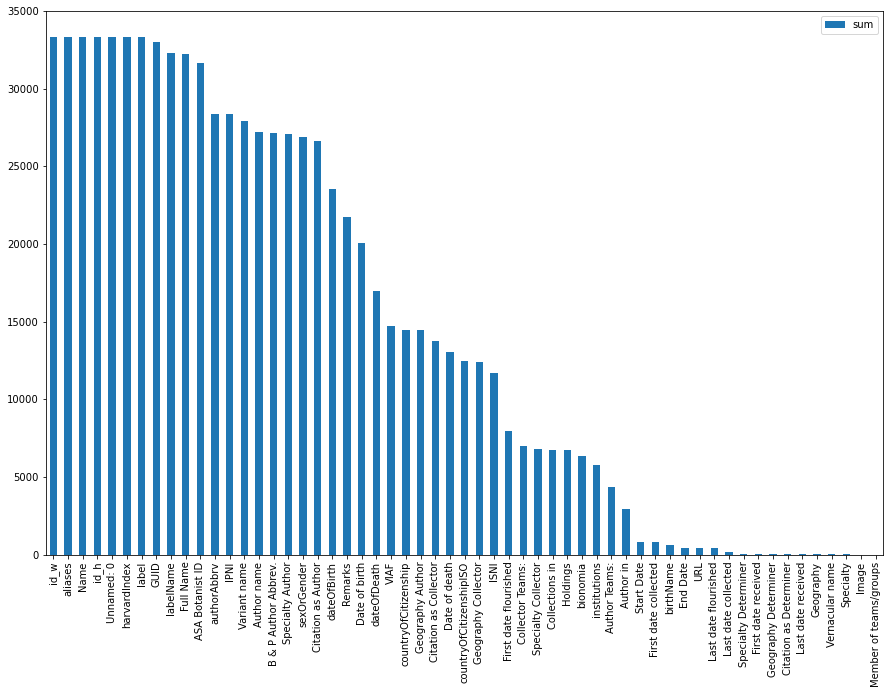

In [183]:
distribution = get_distribution(result, result_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10))

In [184]:
len(set(result['id_h']).intersection(set(result['harvardIndex'])))

33333

In [185]:
result['harvardIndex'].value_counts()

14402.0    2
48540.0    2
62086.0    2
70425.0    2
73340.0    2
          ..
69811.0    1
2271.0     1
61900.0    1
30553.0    1
8283.0     1
Name: harvardIndex, Length: 33333, dtype: int64

In [186]:
a = result['harvardIndex'].value_counts()
b = a.loc[a[:] > 1]
type(b)
print(b)

14402.0     2
48540.0     2
62086.0     2
70425.0     2
73340.0     2
8848.0      2
49444.0     2
64532.0     2
78374.0     2
100463.0    2
79127.0     2
60967.0     2
82562.0     2
Name: harvardIndex, dtype: int64


In [187]:
b.index.astype(int).to_list()

[14402,
 48540,
 62086,
 70425,
 73340,
 8848,
 49444,
 64532,
 78374,
 100463,
 79127,
 60967,
 82562]

In [188]:
options = b.index.astype(int).to_list()
temp = result.loc[result['harvardIndex'].isin(options)]
## temp

In [189]:
options = ['William Watson']
temp = result.loc[result['label'].isin(options)]
print(temp)

            id_w           label institutions            dateOfBirth  \
3810   Q16027659  William Watson          NaN  +1832-01-01T00:00:00Z   
25607    Q462269  William Watson          NaN  +1715-04-03T00:00:00Z   
30301   Q6167759  William Watson          NaN  +1858-01-01T00:00:00Z   

                      ISNI countryOfCitizenshipISO countryOfCitizenship  \
3810   0000 0000 9978 6904                  ['GB']          ['Q174193']   
25607  0000 0000 8362 8792                     NaN          ['Q161885']   
30301  0000 0000 8639 8718                  ['GB']          ['Q174193']   

                                  aliases bionomia            dateOfDeath  \
3810   ['Will.Watson', 'Willliam Watson']      NaN  +1912-01-01T00:00:00Z   
25607                                  []      NaN  +1787-05-10T00:00:00Z   
30301        ['William Watson 1858-1925']      NaN  +1925-01-01T00:00:00Z   

       ...          Author in  Start Date First date received  End Date  \
3810   ...  Rhododendr. Az

In [190]:
options = ['Boutelou, Esteban']
temp = result.loc[result['Name'].isin(options)]
print(temp)

           id_w                          label institutions  \
28765  Q5849022               Esteban Boutelou          NaN   
28767  Q5849923  Estéban Boutelou y Soldevilla          NaN   

                 dateOfBirth                 ISNI countryOfCitizenshipISO  \
28765  +1776-00-00T00:00:00Z  0000 0001 1473 2585                  ['ES']   
28767  +1823-08-08T00:00:00Z  0000 0001 1861 3591                  ['ES']   

      countryOfCitizenship                                            aliases  \
28765              ['Q29']             ['Boutelou', 'Esteban Boutelou Agraz']   
28767              ['Q29']  ['E.Boutelou', 'Esteban Boutelou', 'Boutelou y...   

       bionomia            dateOfDeath  ... Author in  Start Date  \
28765  Q5849022  +1813-00-00T00:00:00Z  ...       NaN         NaN   
28767  Q5849923  +1883-02-14T00:00:00Z  ...       NaN         NaN   

      First date received  End Date Specialty  URL  Last date received  \
28765                 NaN       NaN       NaN  NaN  

In [191]:
print(result['label'].value_counts())
print(result['Name'].value_counts())

Robert Brown             3
Karl Müller              3
William Watson           3
Albrecht von Haller      2
Jie Chen                 2
                        ..
Chris K. Kjeldsen        1
Frederic Kitton          1
Christian Kittler        1
Mary Teresita Kittell    1
James Cook               1
Name: label, Length: 33287, dtype: int64
Watson, William              3
Boutelou, Esteban            2
Vahl, Martin                 2
Kickx, Jean                  2
Lopes, Maria Helena Ramos    2
                            ..
Klein, Roberto Miguel        1
Klein, Johann Gottfried      1
Klazenga, Niels              1
Klastersky, Ivan             1
Cook, James                  1
Name: Name, Length: 33307, dtype: int64


                             sum
id_x                     1817355
id_y                     1817355
Unnamed: 0               1817355
aliases                  1817355
Name                     1816363
sexOrGender              1691682
dateOfBirth              1654998
GUID                     1506859
dateOfDeath              1105756
Remarks                  1047863
VIAF                      900724
B & P Author Abbrev.      783374
ASA Botanist ID           676301
countryOfCitizenship      542019
institutions              527202
countryOfCitizenshipISO   241835
ISNI                      153920
Author name               135881
harvardIndex               44768
birthName                  43930
Full Name                  35919
authorAbbrv                30755
IPNI                       30755
Specialty Author           29486
Variant name               28931
Citation as Author         21229
First date flourished      18859
Geography Author           17056
URL                        16379
Date of bi

<AxesSubplot:>

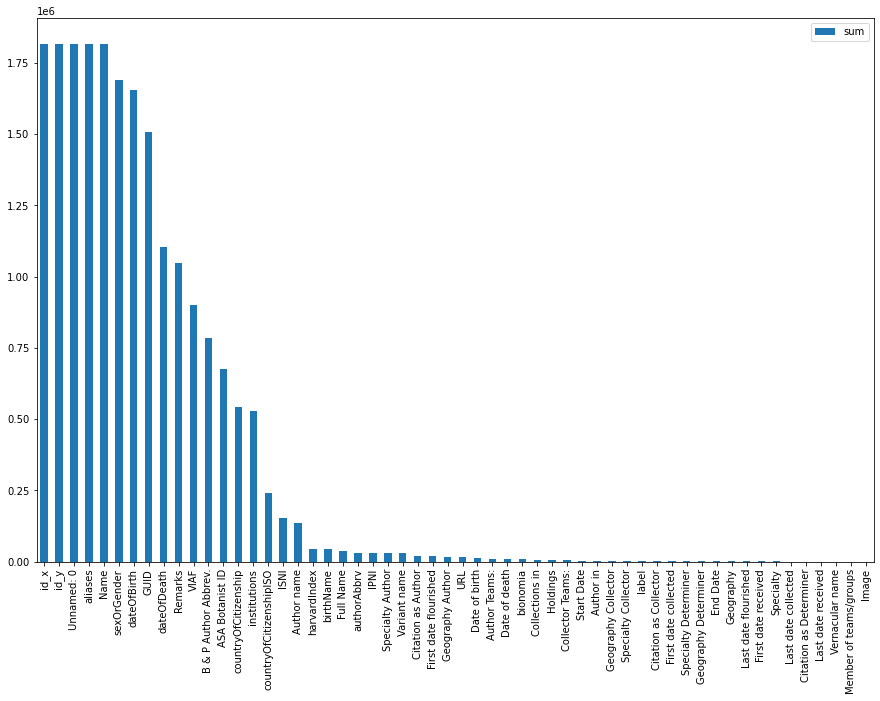

In [180]:
## result2 = pd.merge(wiki_data, harvard_data, how='inner', on=None, left_on='label', right_on='labelName',
##                   left_index=False, right_index=False, sort=False,
##                   suffixes=('_w', '_h'), copy=False)

result2 = wiki_data.merge(harvard_data, on='label')
result2_columns = result2.columns.tolist()
distribution = get_distribution(result2, result2_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10))

In [154]:
result2['id_w'].value_counts()

Q23673978    7321
Q29453438    7321
Q25461079    7321
Q25465389    7321
Q25532585    7321
             ... 
Q33667102       1
Q33666870       1
Q33664819       1
Q33664780       1
Q23139          1
Name: id_w, Length: 1897, dtype: int64

ModuleNotFoundError: No module named 'spacy'